In [1]:
# KNN practice with titanic dataset
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../datasets/Titanic-Dataset.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# select the object dtype columns 
categorical_cols = data.select_dtypes(include=['object']).columns
# drop except survived
data = data.drop(columns=[col for col in categorical_cols if col != 'Survived'])
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
dtype: object

In [4]:
# Drop the missing data using a condition 
missing_info = data.isnull().sum() / len(data) * 100

for col in data.columns:
  if(missing_info[col] > 10):
    data.fillna({ col : data[col].mean()}, inplace=True)
  else:
    data.dropna(subset=[col], inplace=True)

In [5]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [8]:
def train_test_split(X: np.ndarray, y: np.ndarray, test_size=0.3, random_seed=42):
    """
    Splits dataset into train and test sets.
    Arguments:
      X : np.ndarray
        Feature matrix.
      y : np.ndarray
        Target array.
      test_size : float
        Proportion of the dataset to include in the test split (0 < test_size < 1).
      random_seed : int
        Seed for reproducibility.
    Returns:
      X_train, X_test, y_train, y_test : np.ndarray
        Training and testing splits of features and target.
    """
    np.random.seed(random_seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [11]:
X = data.drop(columns='Survived').values
y = data['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (624, 6)
Shape of X_test: (267, 6)
Shape of y_train: (624,)
Shape of y_test: (267,)


In [18]:
def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    """
    Calculate the Euclidean distance between two points in n-dimensional space.
    Arguments:
      point1 : np.ndarray
        The first point as a numpy array.
      point2 : np.ndarray
        The second point as a numpy array.
    Returns:
      float
        The Euclidean distance between the two points.
    Raises:
      ValueError: If the input points do not have the same dimensionality.
    """
    if point1.shape != point2.shape:
        raise ValueError(
            "The dimensions of two points must be same to calculate euclidean distance"
        )
    return np.sqrt(np.sum((point2 - point1) ** 2))

In [20]:
# Test case for function
try:
  point1 = np.array([3, 4])
  point2 = np.array([0, 0])
  result = euclidean_distance(point1, point2)
  expected_result = 5.0
  assert np.isclose(result, expected_result), f"Expected {expected_result}, got {result}"
  print("Test Passed Successfully")
except ValueError as ve:
  print(f"ValueError: {ve}")
except AssertionError as ae:
  print(f"AssertionError: {ae}")
except Exception as e:
  print(f"Error occured: {e}")

Test Passed Successfully


In [22]:
# Function for KNN prediction for a single query
def knn_single_predict(
    query: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, k=3
) -> int:
    """
    Predict the class label for a single query using the K-nearest neighbors algorithm.
    Arguments:
      query : np.ndarray
        The query point for which the prediction is to be made.
      X_train : np.ndarray
        The training feature matrix.
      y_train : np.ndarray
        The training labels.
      k : int, optional
        The number of nearest neighbors to consider (default is 3).
    Returns:
      int
        The predicted class label for the query.
    """
    distances = [euclidean_distance(query, x) for x in X_train]
    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:k]
    nearest_labels = y_train[nearest_indices]
    prediction = np.bincount(nearest_labels).argmax()
    return prediction

In [23]:
def knn_predict(
    X_test: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, k=3
) -> np.ndarray:
    """
    Predict the class labels for all test samples using the K-nearest neighbors algorithm.
    Arguments:
      X_test : np.ndarray
        The test feature matrix.
      X_train : np.ndarray
        The training feature matrix.
      y_train : np.ndarray
        The training labels.
      k : int, optional
        The number of nearest neighbors to consider (default is 3).
    Returns:
      np.ndarray
        An array of predicted class labels for the test samples.
    """

    predictions = [knn_single_predict(x, X_train, y_train) for x in X_test]
    return np.array(predictions)

In [26]:
# Test case for KNN on the Titanic dataset
try:
# Define the test set for the test case
  X_test_sample = X_test[:5] 
  y_test_sample = y_test[:5] 
  predictions = knn_predict(X_test_sample, X_train, y_train, k=3)
  print("Predictions:", predictions)
  print("Actual labels:", y_test_sample)
  assert predictions.shape == y_test_sample.shape, "The shape of predictions does not match the shape of the actual labels."
  print("Test case passed successfully!")
except AssertionError as ae:
  print(f"AssertionError: {ae}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Predictions: [0 1 0 0 0]
Actual labels: [1 0 0 1 1]
Test case passed successfully!


In [27]:
def compute_accuracy(y_true: np.ndarray, y_predict: np.ndarray) -> float:
  """
  Compute the accuracy of predictions.
  Arguments:
    y_true : np.ndarray ; The true labels.
    y_pred : np.ndarray; The predicted labels.
  Returns:
    float : The accuracy as a percentage (0 to 100).
  """
  total_correct_predictions = np.sum(y_true == y_predict)
  total_predictions = len(y_true)
  accuracy = total_correct_predictions / total_predictions * 100
  return accuracy

In [28]:
# Perform prediction on the entire test set
try:
  predictions = knn_predict(X_test, X_train, y_train, k=3)
  accuracy = compute_accuracy(y_test, predictions)
  print(f"Accuracy of the KNN model on the test set: {accuracy:.2f}%")
except Exception as e:
  print(f"An unexpected error occurred during prediction or accuracy computation: {e}")

Accuracy of the KNN model on the test set: 61.80%


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def experiment_knn_k_values(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    k_values: list[int],
):
    """
    Run KNN predictions for different values of k and plot the accuracies.
    Arguments:
      X_train : np.ndarray
        The training feature matrix.
      y_train : np.ndarray
        The training labels.
      X_test : np.ndarray
        The test feature matrix.
      y_test : np.ndarray
        The test labels.
      k_values : list of int
        A list of k values to experiment with.
    Returns:
      dict
        A dictionary with k values as keys and their corresponding accuracies as values.
    """
    accuracies = {}
    for k in k_values:
        predicted_values = knn_predict(X_test, X_train, y_train, k)

        accuracy = compute_accuracy(y_test, predicted_values)
        accuracies[k] = accuracy
        print(f"Accuracy for k={k}: {accuracy:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, list(accuracies.values()), marker='o')
    plt.title('Accuracy of KNN with Different Values of k')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()
    return accuracies

Accuracy for k=1: 61.80%
Accuracy for k=2: 61.80%
Accuracy for k=3: 61.80%
Accuracy for k=4: 61.80%
Accuracy for k=5: 61.80%
Accuracy for k=6: 61.80%
Accuracy for k=7: 61.80%
Accuracy for k=8: 61.80%
Accuracy for k=9: 61.80%
Accuracy for k=10: 61.80%
Accuracy for k=11: 61.80%
Accuracy for k=12: 61.80%
Accuracy for k=13: 61.80%
Accuracy for k=14: 61.80%


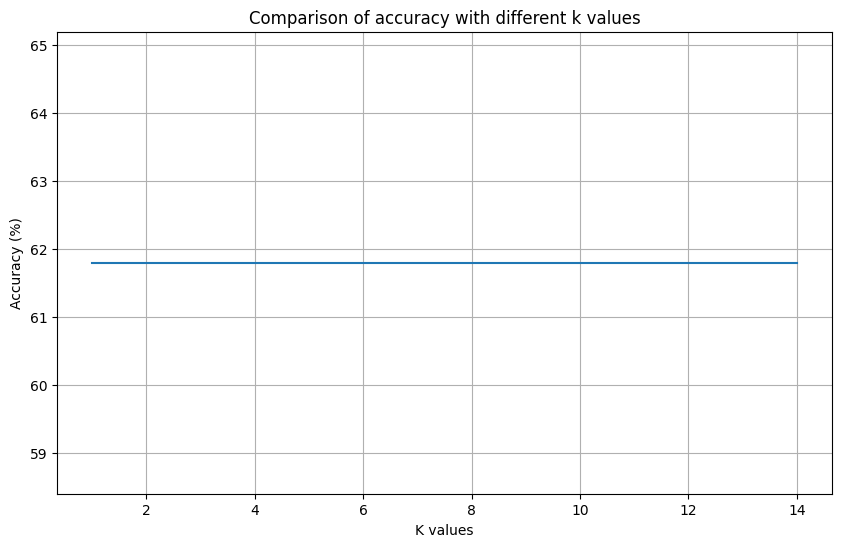

Experiment completed. Check the plot for the accuracy trend.


In [36]:
k_values = range(1, 15) 
try:
    accuracies = experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values)
    print("Experiment completed. Check the plot for the accuracy trend.")
except Exception as e:
    print(f"An unexpected error occurred during the experiment: {e}")